In [1]:
import os
import sys
import h5py
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy import signal
from scipy.stats import norm, pearsonr
from itertools import combinations
from scipy.ndimage.filters import gaussian_filter
from sklearn.decomposition import IncrementalPCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold
%matplotlib inline

In [2]:
# database full path
database_name = 'whistlers.h5'
database_location = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'Data')
database_path = os.path.join(database_location,database_name)

# data variables
awd_events = 2
sites = ['marion', 'sanae']

In [3]:
def extract_spectrogram_info(spectrogram_data):
    '''Extract the time, frequency axis values as well as the 
            spectrogram data.
    inputs:
        spectrogram_data: the spectrogram data including the 
        time and frequency information.
    outputs: 
        time: time values
        frequency: frequency values
        spectrogram: spectrogram
    '''
    time = spectrogram_data[0,1:]
    frequency = spectrogram_data[1:,0]
    spectrogram = spectrogram_data[1:,1:]
    return time, frequency, spectrogram

def reshape_spectrogram(f, t, s):
    f = np.asarray(f)
    t = np.asarray(t)
    s = np.asarray(s)
    _t = np.concatenate(([0],t))
    _s = np.concatenate((f[np.newaxis].T,s), axis=1)
    sft = np.vstack((_t,_s))
    return sft

In [4]:
file_durations = []
site_recording_frq = 257
site_recording_time = [2630, 1262]
gaussian_site_noise = []
gaussian_mean = (0,0)
gaussian_cov = [[0,0],[0,1]]

for awd_event in range(1,awd_events):
    for site in range(len(sites)):
        temp = []
        f  = h5py.File(database_path, 'r')
        grp_wh = f[os.path.join('awdEvents'+str(awd_event), sites[site],'split_dataset')]
        files = list(grp_wh.keys())
#         for file in files:
#             temp.append(grp_wh[file].shape[1])
        f.close()
#         file_durations.append(np.asarray(temp))
        print(sites[site],len(files))


for site in range(len(sites)):
    gaussian_site_noise.append(np.random.multivariate_normal(gaussian_mean, gaussian_cov, 
                                                             (site_recording_frq, site_recording_time[site]))[:,:,0])

marion 8531
sanae 1350


In [5]:
def vstack_uneven(base_arr, added_arr):
    index = added_arr.shape[1]
    arr = np.zeros(shape=base_arr.shape)
    arr[:,:index] = added_arr + base_arr[:,:index]
    arr[:,index:] = base_arr[:,index:]
    return arr

In [22]:
'''Extract data and aplly incremental PCA
'''
start = time.time()
for awd_event in range(1,awd_events):
    for site in range(len(sites)):

        indexes = []
        targets = []
        
        f  = h5py.File(database_path, 'r+')
        grp = f[os.path.join('awdEvents'+str(awd_event), sites[site],'split_dataset')]
        files = list(grp.keys())

        print('\nPCA for %s/%s' %('awdEvent'+str(awd_event),sites[site]))
        
        # PCA parameters
        n_batches = 20
        batch_size = math.ceil(len(files)/n_batches)
        
#         _range = range(int(len(files)/100))
        
        # for each batch
        for batch in range(n_batches-1):
            # extract data
            last_percent = None
            num_file = 0
            percent = 0
            data = []
            # apply incremental PCA
            print("\nExtracting and incPCA on batch", batch)
            for num_file in range(batch*batch_size, (batch+1)*batch_size):
                file = files[num_file]
                file_data = np.empty(grp[file].shape)
                grp[file].read_direct(file_data)
                # extract spectrogram
                _t,_f,Sxx = extract_spectrogram_info(file_data)
                # add noise
                Sxx = vstack_uneven(gaussian_site_noise[site], Sxx)
                Sxx = Sxx.flatten()
                # reduce by the mean
                Sxx -= np.mean(Sxx) # PCA from sklearn does it automatically
                Sxx = Sxx.tolist()
                # add event boolean
                targets.append(grp[file].attrs['event'])
                # update data and indexes
                data.append(Sxx) # data for each batch
                indexes.append(file) # index for the whole set

                # print progress
                percent = int((num_file%batch_size)*100/batch_size)
                if last_percent != percent:
                    if percent%10==0:
                        sys.stdout.write("%s%%" % percent)
                        sys.stdout.flush()
                    else:
                        sys.stdout.write(".")
                        sys.stdout.flush()
                    last_percent = percent
        
            # incremental PCA
            data = np.asarray(data, dtype=np.float32)
            data, err = manifold.locally_linear_embedding(data, n_neighbors=12, n_components = 3,method='modified')
            break # just one bacth
        f.close()
        break # only for marion
end = time.time()
print("\nRuntime: {:.2f} seconds".format(end - start))


PCA for awdEvent1/marion

Extracting and incPCA on batch 0
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 155.33 seconds


In [23]:
data = np.asarray(data, dtype=np.float32)
data = np.vstack(data[:])
targets = targets[:data.shape[0]]

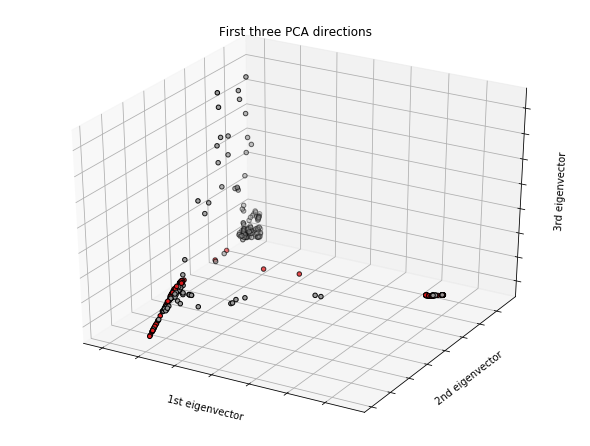

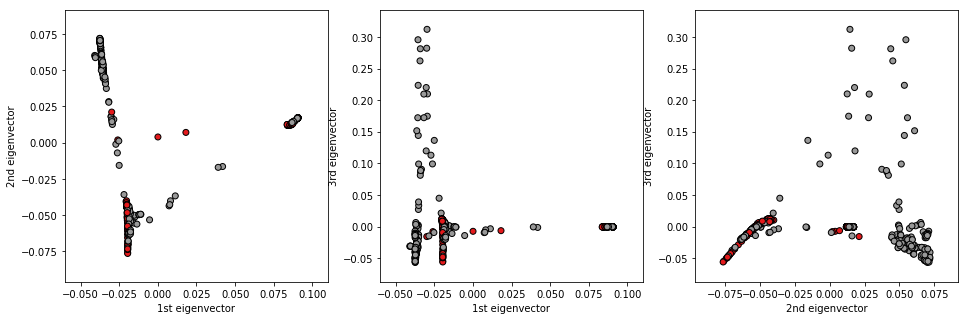

In [24]:
# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig)

ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=targets,
           cmap=plt.cm.Set1, edgecolor='k', s=20)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.scatter(data[:, 0], data[:, 1], c=targets, cmap=plt.cm.Set1,edgecolor='k')
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
plt.subplot(1,3,2)
plt.scatter(data[:, 0], data[:, 2], c=targets, cmap=plt.cm.Set1,edgecolor='k')
plt.xlabel("1st eigenvector")
plt.ylabel("3rd eigenvector")
plt.subplot(1,3,3)
plt.scatter(data[:, 1], data[:, 2], c=targets, cmap=plt.cm.Set1,edgecolor='k')
plt.xlabel("2nd eigenvector")
plt.ylabel("3rd eigenvector")

plt.show()

In [14]:
err

1.3047055966239322e-09